<a href="https://colab.research.google.com/github/petr-ngn/CNN_Real_Estate_Offices_Amenities_Listing/blob/main/03_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and importing relevant libraries

In [1]:
!pip install keras-tuner
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 26.1 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import RMSprop
from tensorflow.math import square, maximum, reduce_mean, sqrt, reduce_sum
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Lambda
from keras.callbacks import EarlyStopping, TensorBoard
import keras_tuner as kt
from google.colab import drive
import sys
import matplotlib.pyplot as plt
import datetime
tf.get_logger().setLevel('ERROR')
import visualkeras
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

Mounting the Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Importing a costume created module by Petr Nguyen

In [4]:
sys.path.append('/content/drive/MyDrive/Agile_ML/src_PN')

In [5]:
import PN_functions as PN

Setting a path

In [6]:
path = '/content/drive/MyDrive/Agile_ML'
os.chdir(path)

Parameter initialization (to preserve the reproducibility)

In [7]:
random_seed = 1234
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

Setting log files for TensorBoard and callbacks

In [8]:
logs_base_dir_search = "./logs/search/"
logs_base_dir_fit = "./logs/fit/"

for log in [logs_base_dir_search, logs_base_dir_fit]:
  os.makedirs(log, exist_ok = True)

logdir_search = os.path.join(logs_base_dir_search,
                             datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

logdir_fit = os.path.join(logs_base_dir_fit,
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tf_search_callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),
                TensorBoard(logdir_search, histogram_freq = 1)]

tf_fit_callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),
                TensorBoard(logdir_fit, histogram_freq = 1)]

##**Data Preparation**

Loading the image pairs and labels

In [9]:
train_imgs, train_labels = PN.read_pairs('train')
valid_imgs, valid_labels = PN.read_pairs('valid')
test_imgs, test_labels = PN.read_pairs('test')

In [10]:
print(f'number of pairs in training set: {len(train_imgs)}')
print(f'number of pairs in validation set: {len(valid_imgs)}')
print(f'number of pairs in test set: {len(test_imgs)}')

number of pairs in training set: 6300
number of pairs in validation set: 2700
number of pairs in test set: 1000


TensorFlow API Data Processing Pipeline

In [11]:
train_tf = PN.tf_data_processing_pipeline(train_imgs, train_labels)
valid_tf = PN.tf_data_processing_pipeline(valid_imgs, valid_labels)
test_tf = PN.tf_data_processing_pipeline(test_imgs, test_labels)

In [12]:
print('training set:', tf.data.experimental.cardinality(train_tf).numpy())
print('validation set:', tf.data.experimental.cardinality(valid_tf).numpy())
print('test set:', tf.data.experimental.cardinality(test_tf).numpy())

training set: 394
validation set: 169
test set: 63


## **Modelling and Hyperparameter tuning**

Defining Euclidean distance for Lambda layer (in order to calculate the distance between the two predicted feature vectors/distances)

In [13]:
def euclidean_distance(vects):

    # unpack the vectors into separate lists
    x, y = vects

    # compute the sum of squared distances between the vectors
    sum_square = tf.math.reduce_sum(tf.math.square(x - y),
                                    axis = 1, keepdims = True)
    
    # return the euclidean distance between the vectors
    return tf.math.sqrt(tf.math.maximum(sum_square,
                                        tf.keras.backend.epsilon()))

Defining contrastive loss function which we want to minimized within the modelling

In [14]:
def contrastive_loss(margin = 1):

    def contrastive__loss(Y, D):

        return tf.math.reduce_mean(
            Y * tf.math.square(D) + (1 - Y) * tf.math.square(tf.math.maximum(margin - D, 0))
                                  )

    return contrastive__loss

Defining hyperparameter space function

We tune:
- number of convolutional blocks,
- number of filters within the convolution,
- type of the activation function within the convolution (relu, tanh),
- kernel size within the convolution,
- pool size within the pooling,
- type of the pooling (max, average),
- stride values withint the pooling,
- number of units within the last year of CNN (the output layer = feature vector),
- type of the activation function within the last year of CNN (the output layer = feature vector) (relu, tanh),
- learning rate within the root mean square propagation optimizer (RSMprop),
- margin within the contrastive loss function

In [ ]:
def model_building(hp):

  #Input layer
  inputs = Input(shape = (224, 224, 3))
  x = inputs

  #Tuning a number of convolutional blocks
  for i in range(hp.Int('conv_blocks', min_value = 1, max_value = 5,
                        default = 3)):
    
    #Normalization layer
    x = BatchNormalization()(x)

    #Tuning the number of convolution's output filters
    filters = hp.Int(f'filters_{i}', min_value = 32,
                     max_value = 256, step = 32)

    #Tuning the activation function within convolution
    activations = hp.Choice(f'activation_{i}',
                            ['relu','tanh'])

    #Tuning the kernel size within convolution
    kernel_sizes = hp.Choice(f'kernelsize_{i}',
                             [j for j in range(1,11)])

    #Convolution layer
    x = Conv2D(filters, kernel_size= (kernel_sizes,kernel_sizes),
                 activation = activations)(x)

    #Tuning the pool size within pooling
    pool_sizes = hp.Choice(f'poolsizes_{i}',
                           [j for j in range(1,9)])

    #Tuning the strides within pooling
    strides_pool = hp.Choice(f'strides_pool_{i}',
                             [j for j in range(1,6)])

    #Tuning the pooling type in the convolutional block
    if hp.Choice(f'pooling_{i}', ['avg', 'max']) == 'max':

        x = MaxPooling2D(pool_size = (pool_sizes,pool_sizes),
                         strides = (strides_pool,strides_pool))(x)
    else:
      
        x = AveragePooling2D(pool_size = (pool_sizes,pool_sizes),
                         strides = (strides_pool,strides_pool))(x)

  #Global Average Pooling / Flatten/ Normalization layers
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = BatchNormalization()(x)

  #Tuning the number of units and activation function in feature vector layer
  feature_layer = Dense(hp.Int('Dense_units_0', min_value = 10,
                                max_value = 360, step = 10, default = 50),
                                activation=  hp.Choice(f'activation_{0}',
                                         ['relu','tanh']),
                       name = 'feature_layer')(x)

  #Embedding Convolutional neural network model
  embedding_network = Model(inputs, feature_layer, name = 'CNN')

  #Setting an input layer for the image pairs
  input_1 = Input((224, 224, 3), name = 'left_tower')
  input_2 = Input((224, 224, 3), name = 'right_tower')

  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  #Layers for calculation of the Euclidean distance between the two feature vectors
  merge_layer = Lambda(euclidean_distance,
                       name = 'lambda_layer')([tower_1,
                                              tower_2])
  
  #Normalization layer
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)


  #Final output layer (classification whether the images are of the same label/person)
  output_layer = Dense(1, activation = "sigmoid",
                         name = 'output_layer')(normal_layer)

  #Final Siamese neural networks model
  model = Model(inputs=[input_1, input_2], outputs = output_layer, name = 'SNN')

  #Model compilation with root mean square propagation optimizer (RMSProp), contrastive loss and accuracy
  model.compile(optimizer = RMSprop(hp.Float('learning_rate',
                                            min_value = 1e-4, max_value = 0.5,
                                            sampling = 'log')),
                
                  loss = contrastive_loss(hp.Float('margin',
                                            min_value = 0.1, max_value = 1.5,
                                            sampling = 'log')))

  return model

Initializing Bayesian Optimizitation object for searching the best hyperparameter values mentioned above.
- while mininizing contrastive loss function on the validation set,
- with 30 iterations.

In [ ]:
bayes_opt = kt.tuners.BayesianOptimization(model_building,
                                           objective = 'val_loss',
                                           max_trials = 30,
                                           seed = random_seed,
                                           project_name = "Bayes_Opt")

Searching the best hyperparameter values with Bayesian Optimization
- 15 epochs per each iteration with an early stopping after 5 epochs.

In [ ]:
bayes_opt.search(train_tf,
                 validation_data = valid_tf,
                 epochs = 15,
                 callbacks = tf_search_callbacks)

Displaying the best hyperparameter values

In [ ]:
best_hypers = bayes_opt.get_best_hyperparameters(num_trials = 1)[0]
display(best_hypers.values)

{'conv_blocks': 4,
 'filters_0': 192,
 'activation_0': 'tanh',
 'kernelsize_0': 1,
 'poolsizes_0': 1,
 'strides_pool_0': 1,
 'pooling_0': 'max',
 'filters_1': 192,
 'activation_1': 'relu',
 'kernelsize_1': 2,
 'poolsizes_1': 1,
 'strides_pool_1': 5,
 'pooling_1': 'avg',
 'filters_2': 256,
 'activation_2': 'relu',
 'kernelsize_2': 3,
 'poolsizes_2': 2,
 'strides_pool_2': 5,
 'pooling_2': 'max',
 'Dense_units_0': 10,
 'learning_rate': 0.006396187948143116,
 'margin': 0.1,
 'filters_3': 32,
 'activation_3': 'relu',
 'kernelsize_3': 2,
 'poolsizes_3': 1,
 'strides_pool_3': 1,
 'pooling_3': 'avg',
 'filters_4': 32,
 'activation_4': 'relu',
 'kernelsize_4': 1,
 'poolsizes_4': 3,
 'strides_pool_4': 1,
 'pooling_4': 'avg'}

In [ ]:
with open('best_hypers_values.pkl', 'wb') as f:
  pickle.dump(best_hypers.values,f)

Final model buidling

In [ ]:
final_model = bayes_opt.hypermodel.build(best_hypers)

Model visualization

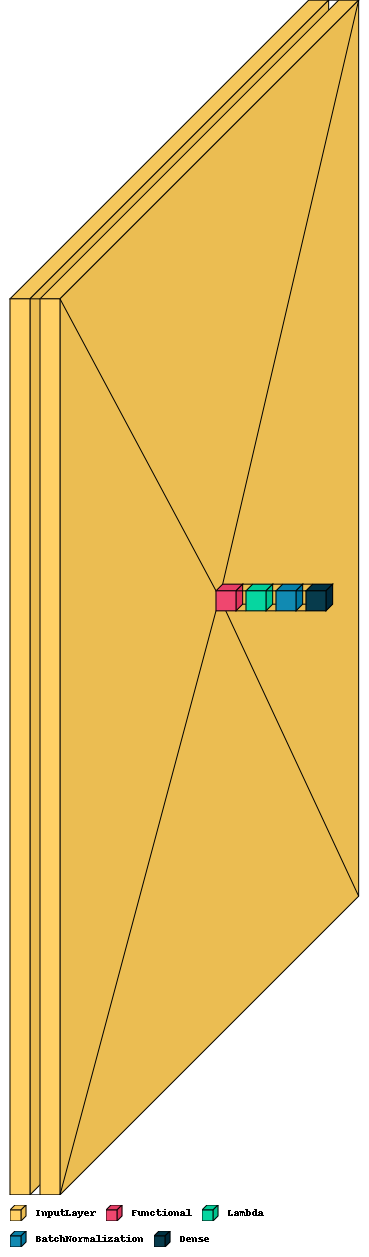

In [ ]:
#Visual Keras
visualkeras.layered_view(final_model, legend = True)

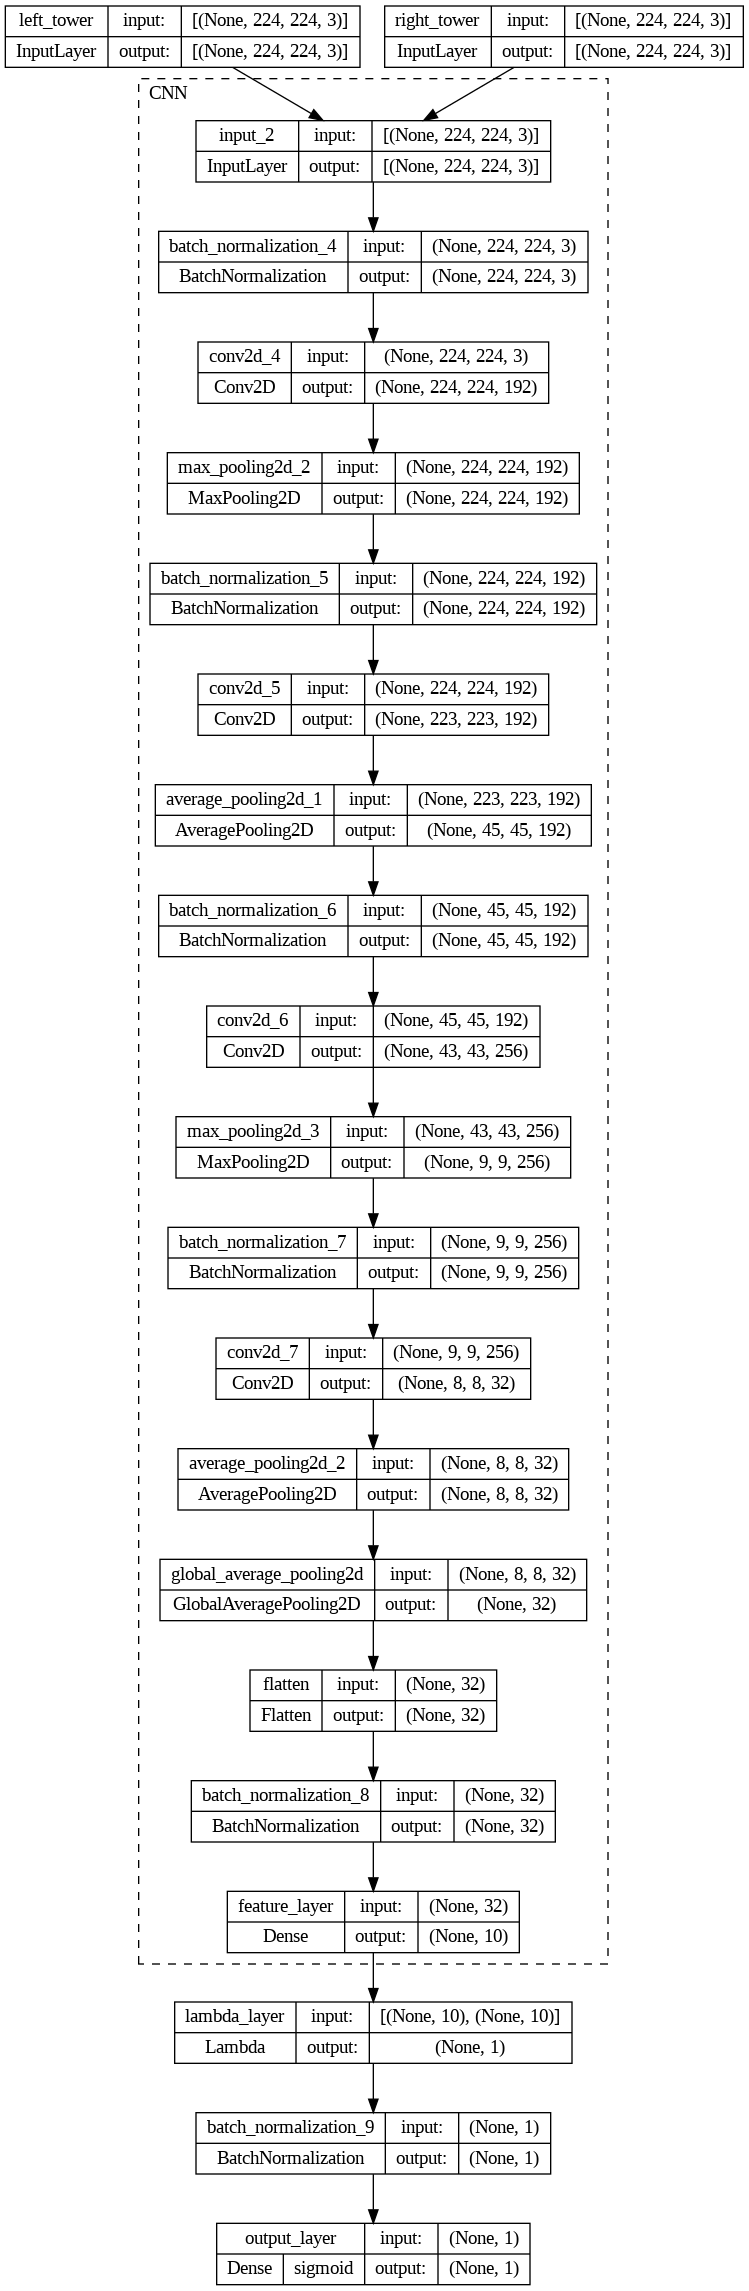

In [ ]:
#Keras Model Plot
tf.keras.utils.plot_model(final_model,
                          show_shapes = True,
                          show_layer_activations = True,
                          show_layer_names = True,
                          expand_nested = True)

In [ ]:
final_model.summary()

Model: "SNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_tower (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_tower (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNN (Functional)               (None, 360)          132692      ['left_tower[0][0]',             
                                                                  'right_tower[0][0]']          

Fitting the final model

In [ ]:
history = final_model.fit(train_tf,
                          epochs = 5, verbose = 1,
                          validation_data = valid_tf,
                          callbacks = tf_fit_callbacks)

Epoch 1/5
394/394 [==============================] - 349s 612ms/step - loss: 0.0249 - val_loss: 0.0023
Epoch 2/5
394/394 [==============================] - 48s 121ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/5
394/394 [==============================] - 48s 121ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/5
394/394 [==============================] - 48s 121ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/5
394/394 [==============================] - 48s 121ms/step - loss: 0.0021 - val_loss: 0.0020


Saving the final model

In [ ]:
final_model.save('Siamese_NN_.h5')

Loss function while training

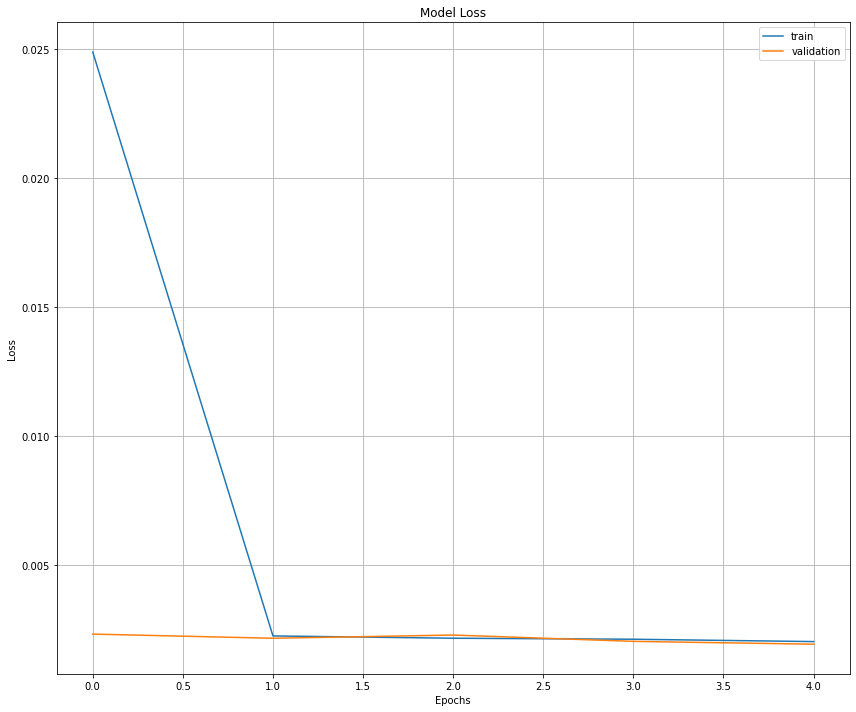

In [ ]:
PN.plot_val_train_loss(history)

## **Evaluation**

Joining the training and validation sets

In [15]:
train_valid_imgs = np.concatenate((train_imgs,valid_imgs),axis = 0)
train_valid_labels = np.concatenate((train_labels,valid_labels),axis = 0)

loading the final Siamese model and extracting the Convolutional Neural Network embedding

In [16]:
final_model = tf.keras.models.load_model('Siamese_NN_.h5', custom_objects = {'contrastive__loss': contrastive_loss})

In [17]:
CNN_model = final_model.get_layer('CNN')

Storing the optimal cutoffs based on particular samples (training /  validation / training-validation / test)

In [18]:
cutoff_dict = {}

In [19]:
for _imgs, _labels, name in zip([train_imgs, valid_imgs, train_valid_imgs, test_imgs],
                                 [train_labels, valid_labels, train_valid_labels, test_labels],
                                 ['train','valid','train_valid','test']):
  
  cutoff_dict[name] = PN.cutoff_derivation(_imgs, _labels, CNN_model)

63/63 [==============================] - 81s 1s/step


In [20]:
cutoff_dict

{'train': 2.772153377532959,
 'valid': 2.761025905609131,
 'train_valid': 2.768815279006958,
 'test': 2.759225845336914}

In [21]:
with open('cutoff_dict.pkl','wb') as f:
  pickle.dump(cutoff_dict, f)

Predicting feature vectors (distances) for left and rights images

In [22]:
test_left_feat_vecs = PN.distance_derivation(test_imgs[:,0], test_labels, CNN_model)
test_right_feat_vecs = PN.distance_derivation(test_imgs[:,1], test_labels, CNN_model)

63/63 [==============================] - 7s 112ms/step


For each cutoff, print the respective accuracy

In [23]:
for name, cutoff in cutoff_dict.items():
  acc, preds, pred_distances = PN.compute_accuracy([i[0] for i in test_labels], test_left_feat_vecs, test_right_feat_vecs, cutoff)
  print(f'{name} ... cutoff: {cutoff} | accuracy: {acc*100:.2f}%')

train ... cutoff: 2.772153377532959 | accuracy: 71.20%
valid ... cutoff: 2.761025905609131 | accuracy: 71.00%
train_valid ... cutoff: 2.768815279006958 | accuracy: 71.20%
test ... cutoff: 2.759225845336914 | accuracy: 71.00%


Confusion matrix

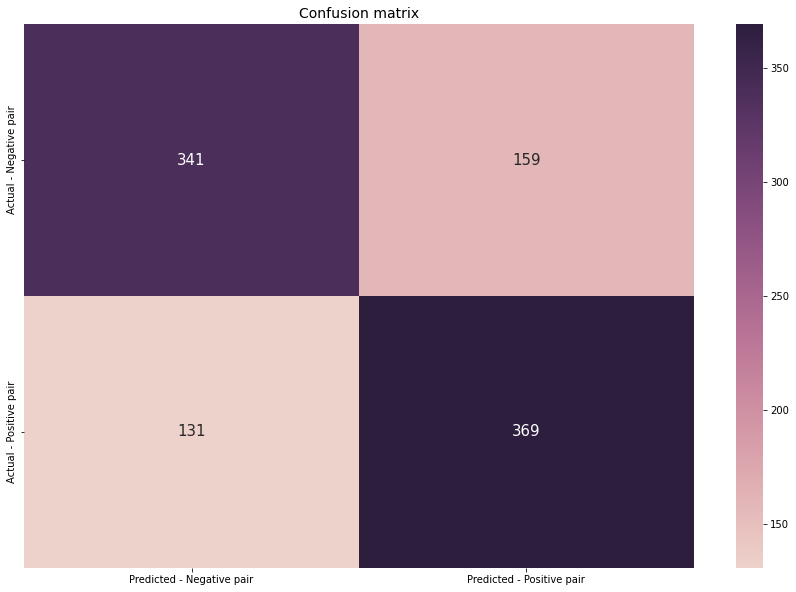

In [24]:
plt.figure(figsize = (15, 10))

sns.heatmap(pd.DataFrame(confusion_matrix([i[0] for i in test_labels], preds)).rename(
                                            columns = {0:'Predicted - Negative pair',
                                                       1:'Predicted - Positive pair'},
                                            index = {0:'Actual - Negative pair',
                                                     1:'Actual - Positive pair'}), 
            annot = True, fmt ='g', cmap=sns.cubehelix_palette(as_cmap = True),
            annot_kws = {"fontsize":15})

plt.title('Confusion matrix', size = 14)
plt.show()